In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE

In [5]:
df= pd.read_csv('../data/sample_limpios.csv')

In [6]:
df

,Unnamed: 0.1,Unnamed: 0,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Total_Packets,Fwd_Bwd_Packet_Ratio,Duration_per_Packet,Bytes_per_Second,Total_Active_Flags
0,262284,279337,53.0,237.0,2.0,2.0,84.0,284.0,42.0,42.0,...,0.0,0.000000e+00,0.0,0.0,benign,4.0,0.666667,3.555000e+02,367.912805,0.0
1,2116004,2944877,53.0,31180.0,2.0,2.0,64.0,532.0,32.0,32.0,...,0.0,0.000000e+00,0.0,0.0,benign,4.0,0.666667,4.677000e+04,577.978626,0.0
2,1292116,1983953,443.0,117731151.0,160.0,192.0,3237.0,376333.0,358.0,0.0,...,9610472.0,1.347232e+06,10000000.0,5332464.0,benign,352.0,0.829016,1.420132e+08,3196.886384,1.0
3,842027,960829,443.0,117461426.0,41.0,36.0,1251.0,40521.0,551.0,0.0,...,58646007.5,7.546456e+04,58699369.0,58592646.0,benign,77.0,1.108108,1.060018e+08,352.621114,1.0
4,152830,162720,80.0,10139751.0,4.0,0.0,24.0,0.0,6.0,6.0,...,10100000.0,0.000000e+00,10100000.0,10100000.0,ddos,4.0,4.000000,2.534938e+06,2.154447,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1796905,2563759,80.0,85952986.0,7.0,4.0,319.0,11595.0,319.0,0.0,...,85800000.0,0.000000e+00,85800000.0,85800000.0,dos hulk,11.0,1.400000,6.139499e+07,137.016571,1.0
99996,1185316,1866658,80.0,6112476.0,4.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.000000e+00,0.0,0.0,benign,5.0,2.000000,3.056238e+06,0.000000,1.0
99997,2059732,2880058,443.0,5745619.0,8.0,6.0,344.0,3747.0,196.0,0.0,...,5466867.0,0.000000e+00,5466867.0,5466867.0,benign,14.0,1.142857,5.027417e+06,606.467694,1.0
99998,1306867,2000583,80.0,5542994.0,3.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.000000e+00,0.0,0.0,benign,4.0,1.500000,3.695329e+06,0.000000,1.0


In [7]:
df = pd.read_csv('../data/datos_limpios.csv')

In [8]:
df = df[~df[" Label"].isin(["heartbleed", "web attack � sql injection"])]

In [9]:
# Separar las características (X) y la variable objetivo (y)
X = df.drop(columns=[' Label'])
y = df[' Label'] 

In [10]:
print("Características (X):", X.columns.tolist())
print("\nVariable objetivo (y):", y.unique()) 

Características (X): ['Unnamed: 0', ' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' URG Flag Count', ' ECE Flag 

In [11]:
# distribución de clases de y
class_distribution = pd.Series(y).value_counts()
print(class_distribution)

 Label
benign                      1809614
dos hulk                     171378
ddos                         127472
portscan                      90407
dos goldeneye                  8806
ftp-patator                    5930
dos slowloris                  3330
ssh-patator                    3216
bot                            1906
web attack � brute force       1468
dos slowhttptest                929
web attack � xss                636
Name: count, dtype: int64


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

###  Sobremuestreo (Oversampling) con SMOTE

Podemos generar más muestras sintéticas de las clases minoritarias usando SMOTE (Synthetic Minority Over-sampling Technique).

In [13]:
# Aplicar SMOTE solo en el conjunto de entrenamiento (¡Nunca en el test!)
smote = SMOTE(sampling_strategy='auto', k_neighbors=1, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verificar la nueva distribución de clases después de SMOTE
print(pd.Series(y_train_resampled).value_counts())

 Label
benign                      1447691
ddos                        1447691
dos hulk                    1447691
bot                         1447691
portscan                    1447691
dos goldeneye               1447691
ssh-patator                 1447691
ftp-patator                 1447691
dos slowhttptest            1447691
web attack � brute force    1447691
dos slowloris               1447691
web attack � xss            1447691
Name: count, dtype: int64


### Random Forest

In [14]:
modelo = RandomForestClassifier(
    n_estimators=50,  # Menos árboles
    max_depth=5,  # Limitar profundidad
    min_samples_leaf=5,  # Mayor número de muestras en cada hoja
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)



scores = cross_val_score(modelo, X, y, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), scoring='accuracy')

print(f"Precisión de cada fold: {scores}")
print(f"Precisión media: {scores.mean()}")

modelo.fit(X_train_resampled, y_train_resampled)

Precisión de cada fold: [0.80567428 0.83315019 0.80192316]
Precisión media: 0.8135825430626086


KeyboardInterrupt: 

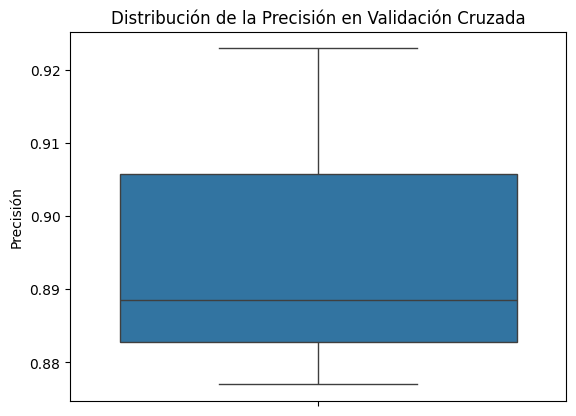

In [ ]:
scores = [0.8885, 0.9229, 0.8770]
sns.boxplot(scores)
plt.title("Distribución de la Precisión en Validación Cruzada")
plt.ylabel("Precisión")
plt.show()

In [ ]:
y_pred = modelo.predict(X_test)

In [ ]:
assert len(y_pred) == len(y_test), "El número de predicciones y etiquetas verdaderas no coincide."

**Para modelos de clasificación, como es el caso de Random Forest, las siguientes métricas son especialmente útiles:**

- Matriz de Confusión: Proporciona una visión detallada de las          predicciones del modelo, mostrando la relación entre las clases         verdaderas y las predichas.

- Exactitud (Accuracy): Indica el porcentaje de predicciones correctas sobre el total de predicciones realizadas.

- Precisión (Precision): Mide la proporción de verdaderos positivos entre todas las instancias que fueron clasificadas como positivas.

- Sensibilidad (Recall) o Tasa de Verdaderos Positivos: Indica la proporción de verdaderos positivos que fueron correctamente identificados por el modelo.

-  Puntuación F1: Es la media armónica entre la precisión y la sensibilidad, proporcionando una medida equilibrada entre ambas.

### Matriz de Confusión, Exactitud, Precisión, Sensibilidad, Puntuación F1

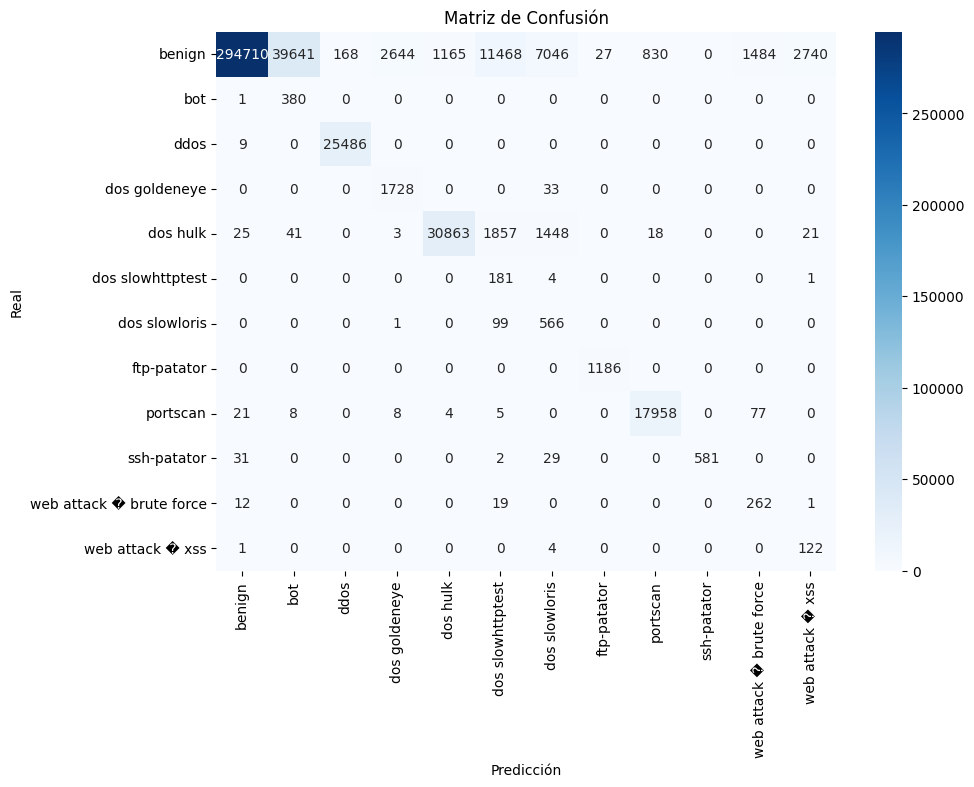

Exactitud: 0.84
Precisión: 0.99
Sensibilidad: 0.84
Puntuación F1: 0.90
[[294710  39641    168   2644   1165  11468   7046     27    830      0
    1484   2740]
 [     1    380      0      0      0      0      0      0      0      0
       0      0]
 [     9      0  25486      0      0      0      0      0      0      0
       0      0]
 [     0      0      0   1728      0      0     33      0      0      0
       0      0]
 [    25     41      0      3  30863   1857   1448      0     18      0
       0     21]
 [     0      0      0      0      0    181      4      0      0      0
       0      1]
 [     0      0      0      1      0     99    566      0      0      0
       0      0]
 [     0      0      0      0      0      0      0   1186      0      0
       0      0]
 [    21      8      0      8      4      5      0      0  17958      0
      77      0]
 [    31      0      0      0      0      2     29      0      0    581
       0      0]
 [    12      0      0      0      0   

In [ ]:
matriz_confusion = confusion_matrix(y_test, y_pred)

# Matriz de Confusión
plt.figure(figsize=(10,7))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# Exactitud
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud: {accuracy:.2f}")

# Precisión
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0.0)
print(f"Precisión: {precision:.2f}")

# Sensibilidad (Recall)
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Sensibilidad: {recall:.2f}")

# Puntuación F1
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Puntuación F1: {f1:.2f}")

print(f"{matriz_confusion}f")

¿Cómo interpretarla?

Por ejemplo, en la primera fila:

- La primera celda muestra cuántos casos de la clase 0 fueron correctamente clasificados como clase 0.
- La segunda celda muestra cuántos casos de la clase 0 fueron incorrectamente clasificados como clase 1.
- Y así sucesivamente.

¿Qué significan los valores clave?

- Diagonal principal: Los valores de la diagonal representan las predicciones correctas para cada clase.
- Fuera de la diagonal: Los valores fuera de la diagonal son los errores de clasificación, es decir, casos en los que el modelo ha predicho una clase equivocada.

### 📈 Curva ROC y AUC (Para Modelos Multiclase)

Si quieres ver cómo se comporta el modelo en términos de sensibilidad vs especificidad, usa la curva ROC y el AUC:

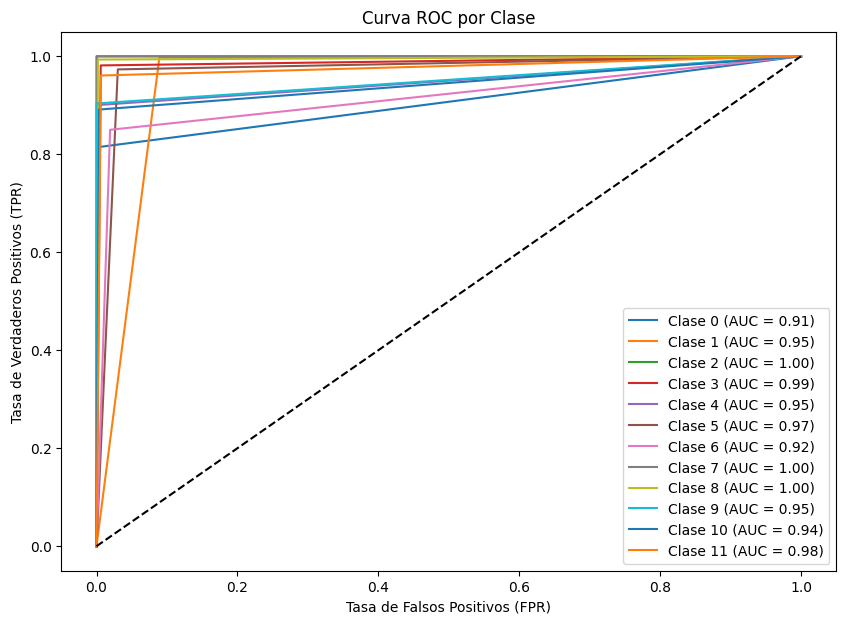

In [ ]:
# Binarizar las etiquetas de y_test
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test))

plt.figure(figsize=(10, 7))

for i in range(y_test_bin.shape[1]): 
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC por Clase")
plt.legend()
plt.show()


- Un AUC cercano a 1 indica que la clase se predice bien.
- Si AUC está cerca de 0.5, significa que el modelo no está diferenciando bien.

In [ ]:
metricas = ["Exactitud", "Precisión", "Sensibilidad", "Puntuación F1"]
valores = [accuracy, precision, recall, f1]

# Crear el gráfico de barras
plt.figure(figsize=(8,5))
plt.bar(metricas, valores, color=['blue', 'green', 'red', 'purple'])

# Agregar valores encima de las barras
for i, v in enumerate(valores):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12, fontweight='bold')

# Configuración del gráfico
plt.ylim(0, 1.1)  # Límite del eje Y para mejor visualización
plt.ylabel("Porcentaje")
plt.title("Rendimiento del Modelo")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()

NameError: name 'accuracy' is not defined